# Preface
This report is part of the final assignment (Capstone Project called "The Battle of the Neighborhoods") of the Coursera course "IBM Data Science Professional Certificate". The other parts are a Notebook with the code [link] and a Blogpost [link]<br>
The assignment is to come up with an idea to use the Foursquare location data to explore or compare neighborhoods or cities of your choice, or to come up with a problem that you can solve with the Foursquare location data.<br>
I took this course to learn and practice the basics of data science with tools such as .. and Python libraries such as pandas, numpy, sklearn, ...
These tools make analyzing data a fascinating and almost addictive activity and I can therefore recommend the course to everyone.

# Introduction

*A brief description of the business problem and a discussion of the background*<br>

Living in the Netherlands, I received a request from a small, completely made-up foreign company.<br>
They have a congress in Amsterdam, but because their company has been in existence for 50 years and they have heard great stories about the sights of Amsterdam, they would like to combine it with a trip for their employees (Corona volente of course).

Because a few employees have difficulty walking, they want to spend the night within walking distance of nice restaurants. They expect to be able to visit the other spots by taxi or public transport. Because they know nothing about the safety of Amsterdam, they have told me that the neighborhood in which they are staying must feel safe.<br>
It would also be nice if I could tell them if there are venue types that are typical for the neighborhood (over-represented) and if so, which ones.<br>
***
They asked me to analyze the neighborhoods and find out which neighborhoods best meet their needs<br>
Perhaps I can give them also some advice on highly rated restaurants of the preferred neighborhoods<br>

So my target audience for this project is this company and other business workers as it can be important also for them to stay in a neighborhood that is both safe and has restaurants within walking distance.


# Data

*A description of the data and how it will be used to solve the problem*<br>

First of all I need the names and coordinates of the neighborhoods of Amsterdam.<br>
Source: https://postcodebijadres.nl/gemeente/amsterdam<br>
This webpage contains the neighborhoods and by calling subpages it should be possible to get their GPS coordinates via webscraping<br>

I also need information about the safety of the neighborhoods<br>
Most recent source I could find:<br>
Document: "Safety index Amsterdam-Amstelland by city districts, 2014-2019"<br>
URL: https://data.amsterdam.nl/datasets/bcy0MclnBpXyDQ/cijfers-veiligheidsindex/<br>

Furthermore I need venue info (restaurants, bars etc) including their coordinates.<br> I have set my hopes on Foursquare. Foursquare has a large database of worldwide location data. Amsterdam receives more than 9 million tourists every year, many of which I hope are active on Foursquare.

Combining and clustering all this information should provide sufficient insight to provide my target audience with an answer.


In [1]:
##################################
## Install and import libraries ##
##################################

In [2]:
!pip install requests  
!pip install lxml  
!pip install bs4   

In [3]:
import pandas as pd
import numpy as np
import requests
import bs4
import urllib.request
from pandas.io.json import json_normalize # to tranform json file into a pandas df
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
from folium.plugins import MiniMap 
%matplotlib inline

## GPS Coordinates of Amsterdam

First I need the GPS coodinates of Amsterdam to be able to position the map with the visualizations.<br>

Grab the webpage using the 'BeautifulSoup' library:

In [4]:
# Grab the page with a.o. Amsterdam GPS coordinates and neighborhoods
adam_raw = requests.get("https://postcodebijadres.nl/gemeente/amsterdam")

In [5]:
# Analyse extracted page with BeautifulSoup
adam_soup = bs4.BeautifulSoup(adam_raw.text,"lxml") # Initiate BeautifulSoup object 

In [6]:
result = adam_soup.prettify().splitlines()
print('\n'.join(result[:15]))

<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!-->
<html class="no-js" lang="en-US">
 <!--<![endif]-->
 <head>
  <title>
   Access denied | postcodebijadres.nl used Cloudflare to restrict access
  </title>
  <meta charset="utf-8"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="IE=Edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="noindex, nofollow" name="robots"/>


That is a setback:
```
<title>Access denied | postcodebijadres.nl used Cloudflare to restrict access</title>
```
The website is using Cloudflare which is a security and content delivery product. All traffic to the website goes through Cloudflare first and obviously Cloudflare has decided that my request is unwanted, so it's blocking me.<br>
As a work around in order to gain access I am going to identify myselve as a web browser. To do so, I am going to fill the 'user-agent' with my browser specifications and associate it with my request:


In [7]:
url = "https://postcodebijadres.nl/gemeente/amsterdam"
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36" # grabbed from my browser

In [8]:
req = urllib.request.Request(url, data=None, headers={"User-Agent": user_agent})
adam_raw2 = urllib.request.urlopen(req).read().decode("utf-8")

In [9]:
print("adam_raw2 has object type : ", type(adam_raw2))
print(adam_raw2[:1000])

adam_raw2 has object type :  <class 'str'>
<!DOCTYPE html>
<html lang="nl">
<head>
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1">
<meta http-equiv="X-UA-Compatible" content="IE=edge">
<title>Postcodes en adressen van de gemeente Amsterdam - Postcode bij adres</title>
<meta name="description" content="Bekijk alle postcodes, straten en adressen van de gemeente Amsterdam in de provincie Noord-Holland. Ontdek ook de demografische gegevens, treinstations en nog veel meer.">
<meta name="keywords" content="gemeente, Amsterdam, Noord-Holland, postcode, postcodes, Nederland, NL">
<meta itemprop="name" content="Postcodes en adressen van de gemeente Amsterdam - Postcode bij adres">
<meta itemprop="description" content="Bekijk alle postcodes, straten en adressen van de gemeente Amsterdam in de provincie Noord-Holland. Ontdek ook de demografische gegevens, treinstations en nog veel meer.">
<meta itemprop="image" content="https://postcodebijadres.nl/img/c

Much better (no access denied).<br>
Now let's get the GPS coodinates of Amsterdam:

In [10]:
adam_soup2 = bs4.BeautifulSoup(adam_raw2,"lxml") # Initiate BeautifulSoup object 

In [11]:
gps_coordinates = adam_soup2.find_all('table', {'class': 'table table-bordered mt-3'})[1].find_all('td')
latitude_adam = float(gps_coordinates[1].text)
longitude_adam = float(gps_coordinates[3].text)
print('latitude of Amsterdam : ', latitude_adam)
print('longitude of Amsterdam : ', longitude_adam)

latitude of Amsterdam :  52.373386505056
longitude of Amsterdam :  4.9045332933391


## Names and GPS coordinates of Amsterdam neighborhoods

First get all neighborhoods by webscraping and put them in a dataframe.

In [12]:
# webscraping a list of neighborhoods and store them in a pandas dataframe
neighborhoods_df = pd.DataFrame(columns=['Neighborhood', 'Neighb_ad', 'Latitude','Longitude']) # setup a neighborhoods dataframe
neighborhoods_raw = adam_soup2.find_all('div', {'class': 'info-block__body'})[1].find_all('a')  # find all neighborhoods
for i in range(len(neighborhoods_raw)-1):
  neighborhoods_df = neighborhoods_df.append({"Neighborhood": neighborhoods_raw[i].text}, ignore_index=True)  # add neighborhoods to the df

print('Dataframe with first 5 Neighborhoods: \n')  
neighborhoods_df.head(5)

Dataframe with first 5 Neighborhoods: 



,Neighborhood,Neighb_ad,Latitude,Longitude
0,Burgwallen-Oude Zijde,NaN,NaN,NaN
1,Burgwallen-Nieuwe Zijde,NaN,NaN,NaN
2,Grachtengordel-West,NaN,NaN,NaN
3,Grachtengordel-Zuid,NaN,NaN,NaN
4,Nieuwmarkt/Lastage,NaN,NaN,NaN


Second get GPS coordinates of neighborhoods:<br>

For that I need to compile a URL-call with pre-requisites:
- lower case characters
- remove special characters '(),/' f.e. `Bijlmer Oost (E,G,K)` has to become `bijlmer-oost-egk`
- replace spaces with '-' and some other adjustments

In [13]:
# function to convert characters in Neighborhoodnames so they can be used for the GPS URL 
def convert_neighb_name(name):
  result_name = str(name).lower()  # lower case
  for item in (['(', ')', ',','/','.']):
    result_name = result_name.replace(item,'')
  result_name = result_name.replace(' ','-')
  result_name = result_name.replace('é','e')
  result_name = result_name.replace('spaarndammer--','spaarndammer-')
  return result_name

In [14]:
# Call to the convert function: result is column Neighb_ad filled with adjusted neighborhood names 
neighborhoods_df['Neighb_ad'] = neighborhoods_df.apply(lambda x: convert_neighb_name(x['Neighborhood']), axis=1)

In [15]:
neighborhoods_df.head(5)

,Neighborhood,Neighb_ad,Latitude,Longitude
0,Burgwallen-Oude Zijde,burgwallen-oude-zijde,NaN,NaN
1,Burgwallen-Nieuwe Zijde,burgwallen-nieuwe-zijde,NaN,NaN
2,Grachtengordel-West,grachtengordel-west,NaN,NaN
3,Grachtengordel-Zuid,grachtengordel-zuid,NaN,NaN
4,Nieuwmarkt/Lastage,nieuwmarktlastage,NaN,NaN


Now get GPS coordinates of neighborhoods, add them to the dataframe and check results

In [16]:
# Function to retrieve GPS coodinates from Amsterdam 'postcodebijadres' page
def find_coordinates(soup):
  gps_coordinates = soup.find_all('table', {'class': 'table table-bordered mt-3'})[1].find_all('td')
  latitude = gps_coordinates[1].text
  longitude = gps_coordinates[3].text
  return latitude, longitude

In [17]:
# Call to the page with GPS coordinates, make it a soup object, and call with the soup-object to the 'find_coordinates'function
# Store the coordinates in the dataframe
# This code might takes a while ...
for i in range(len(neighborhoods_df['Neighb_ad'])):
  url = "https://postcodebijadres.nl/gemeente/amsterdam/wijk/"+ neighborhoods_df['Neighb_ad'][i]  # setting up the URL
  user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36" # grabbed from my browser
  req = urllib.request.Request(url, data=None, headers={"User-Agent": user_agent})
  neighb_raw = urllib.request.urlopen(req).read().decode("utf-8")    

  neighb_soup = bs4.BeautifulSoup(neighb_raw,"lxml")                                                 # Initiate BeautifulSoup object 
  neighborhoods_df['Latitude'][i] , neighborhoods_df['Longitude'][i] = find_coordinates(neighb_soup) # call 'find_coordinates' function to get the coordinates and store stem in df

In [18]:
print('Number of rows :', neighborhoods_df.shape[0])
print('Number of empty fields :\n', neighborhoods_df[['Latitude','Longitude']].isnull().sum(),'\n') # check whether all Neighborhoods have GPS coordinates
print('Check data types : ', neighborhoods_df.info())
print('Content sample :')
neighborhoods_df.sample(5)

Number of rows : 100
Number of empty fields :
 Latitude     0
Longitude    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Neighborhood  100 non-null    object
 1   Neighb_ad     100 non-null    object
 2   Latitude      100 non-null    object
 3   Longitude     100 non-null    object
dtypes: object(4)
memory usage: 3.2+ KB
Check data types :  None
Content sample :


,Neighborhood,Neighb_ad,Latitude,Longitude
51,IJburg Zuid,ijburg-zuid,52.34933951649,5.0063665522843
41,Van Galenbuurt,van-galenbuurt,52.371548538177,4.8496952566006
26,Zuid Pijp,zuid-pijp,52.350523864824,4.9024363812246
78,Geuzenveld,geuzenveld,52.379000814231,4.8019565291168
60,Volewijck,volewijck,52.392605996653,4.9132596893241


Data type of columns Latitude and Longitude are strings. Change that into floats.

In [19]:
neighborhoods_df["Latitude"]=neighborhoods_df["Latitude"].astype(float)
neighborhoods_df["Longitude"]=neighborhoods_df["Longitude"].astype(float)
print('Check Data types : ', neighborhoods_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  100 non-null    object 
 1   Neighb_ad     100 non-null    object 
 2   Latitude      100 non-null    float64
 3   Longitude     100 non-null    float64
dtypes: float64(2), object(2)
memory usage: 3.2+ KB
Check Data types :  None


Visualize neighborhoods

In [20]:
adam_map = folium.Map(location=[latitude_adam, longitude_adam], zoom_start=12, width='100%', height='100%')
map_small = MiniMap(position = 'topleft', center_fixed = (latitude_adam, longitude_adam), zoom_level_fixed = 8)
map_small.add_to(adam_map)

for lat, lng, neighborhood in zip(neighborhoods_df['Latitude'], neighborhoods_df['Longitude'], neighborhoods_df['Neighborhood']):
    label = neighborhoods_df['Neighborhood'][i]
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(adam_map)
adam_map

## Information about the safety of Amsterdam neighborhoods

Most recent data I could find is from 2017<br>
Source: "Safety index Amsterdam-Amstelland by city districts, 2014-2019"<br>
URL: https://data.amsterdam.nl/datasets/bcy0MclnBpXyDQ/cijfers-veiligheidsindex/<br>
According to the safety dashboard of Amsterdam (and adjacent cities), safety has only increased since then, so 2017 seems a safe choice.<br><br>
The file contains all kinds of crime info of all neighborhoods but safety does not depend only on crime. Nuisance from, for example, drunk people on the street or young people is also an influence. It is also important how safe one feels in the neighborhood. Luckily for me the file contains a safety index number, composed of crime, nuisance and perception of insecurity. 

Download relevant part of the dataset containing safety information of Amsterdam neighborhoods in a dataframe

In [21]:
adam_safety = pd.read_excel('https://api.data.amsterdam.nl/dcatd/datasets/bcy0MclnBpXyDQ/purls/3',
                       sheet_name='Vi mei2016_april 2017',  
                       skiprows=range(5) )
#print ('Data read into a pandas dataframe!')

In [22]:
print('First 5 rows: \n') 
adam_safety.head()

First 5 rows: 



,Unnamed: 0,Unnamed: 1,Unnamed: 2,veiligheidsindex,ipsl_risicoperceptie,ipsl_onveiligheidsgevoelens,ipsl_vermijding,Onveiligheidsbelevingindex,Ipersonenoverlast,Iverloedering,overlastindex,HICindex,HVCIndex,criminaliteitsindex,Unnamed: 14,Slachtof_MEAN,HoevCrim_MEAN,VerandCrim_MEAN,OnveiligheidBuurt_MEAN,OnveiligheidAlgemeen_MEAN,rapportcijfer_veiligheid_buurt_MEAN,NietOpen_MEAN,Omloop_MEAN,StrLoopt_MEAN,Alleen_MEAN,Geen_activieit_avond_MEAN,niet_alleen_buiten_MEAN,HoevOverlastBuurt_MEAN,VerandOverlastBuurt_MEAN,risicoperceptie,onveiligheidsgevoelens,vermijding,Rommel_MEAN,Verniel_MEAN,Beklad_MEAN,HondPoep_MEAN,onderhoud_straat_MEAN,onderhoud_groen_MEAN,Dronken_MEAN,Drugs_MEAN,...,ipsl_autodiefstal,ipsl_Diefstal_ander_motorvoertuig,ipsl_fietsdiefstal,ipsl_beroving,ipsl_zakkenrollerij,ipsl_mishandeling,ipsl_bedreiging,ipsl_sexuele_int_gew,ipsl_overige_diefstal,ipsl_vernielingen,ipsl_inbraak_totaal,ipsl_brom_snor_samen,Izeden,Imoorddood,Ibedreig,Imishandeling_en_geweld,Istraatroof,Ioverval,Iinbrwoning,Iinbrbox,Iuitauto,Ivanpersauto,Ifietsdief,Ibromsnorfiets,Ioverigvoertuig,Ivermogen,Iinbrbedr,Iwinkel,Izakrol,N_wijk,pop,nwoninge,nwink,nbedr,werkpers,student,bezoek,nbezoek,verbtot3,verbnieuw
0,A00,1,Burgwallen-Oude Zijde,175.88,135.21,95.87,75.37,102.15,458.30,149.51,303.90,101.81,141.36,121.58,NaN,19.65,78.45,57.63,14.15,15.43,45.80,14.62,17.87,21.91,4.11,12.52,8.87,86.94,73.93,72.88,20.24,14.15,62.27,18.09,24.61,27.02,35.65,36.20,68.09,48.48,...,222.94,55.28,150.11,153.52,156.95,105.91,95.25,170.91,174.05,217.20,84.62,55.88,129.21,139.36,74.22,119.38,199.68,117.74,61.62,54.08,73.87,80.78,90.62,39.69,44.24,260.79,110.49,147.31,511.69,73.19,4290,2864,184,1879,7090,1746,80626,89462.14,34110.71,16949.85
1,A01,2,Burgwallen-Nieuwe Zijde,190.19,114.80,91.64,66.37,90.94,548.26,139.81,344.04,107.85,163.34,135.59,NaN,15.11,67.31,52.08,17.89,20.09,41.46,17.45,15.40,19.32,1.84,11.76,5.15,71.35,58.90,61.88,19.34,12.46,57.77,25.32,28.52,27.38,35.46,34.44,56.58,38.29,...,0.00,64.45,207.78,178.85,182.84,172.55,155.18,278.45,101.77,256.62,87.13,65.15,190.57,116.04,101.88,141.60,160.60,58.82,72.86,77.70,57.20,8.07,168.88,54.29,69.85,288.32,260.93,272.14,375.97,73.69,3981,2791,523,2081,10539,1689,139692,151919.71,54620.90,25166.59
2,A02,3,Grachtengordel-West,84.96,103.94,62.54,41.34,69.27,151.24,93.54,122.39,47.01,79.44,63.23,NaN,11.29,50.07,54.05,7.21,11.96,36.02,11.41,8.65,10.20,2.20,6.89,2.96,58.81,68.11,56.02,13.20,7.76,41.26,9.84,14.76,26.73,29.96,27.39,30.02,17.61,...,145.18,117.34,199.87,45.68,46.70,45.21,40.66,72.95,150.33,126.34,46.71,118.60,68.28,33.92,31.60,39.97,73.07,34.39,82.03,0.00,128.47,95.59,118.86,83.48,84.62,107.02,82.17,15.55,78.65,109.14,6483,4320,227,2721,6678,0,43940,50617.65,23355.55,14201.46
3,A03,4,Grachtengordel-Zuid,153.32,116.48,83.82,51.93,84.08,270.37,142.30,206.34,159.23,179.87,169.55,NaN,23.41,63.07,53.75,12.32,15.56,36.80,16.65,10.20,13.53,4.12,7.59,2.32,66.44,65.26,62.78,17.69,9.75,45.91,14.41,20.37,27.94,33.88,31.63,45.23,21.53,...,60.07,104.73,188.68,144.45,147.68,214.22,192.66,345.70,140.22,210.03,78.06,105.85,259.82,171.65,128.41,307.11,228.01,0.00,105.44,14.18,200.76,67.78,170.39,111.26,115.49,366.10,90.91,42.18,619.64,89.46,5455,3347,272,2401,9566,0,29459,39025.37,18463.46,12326.09
4,A04,5,Nieuwmarkt/Lastage,113.79,106.26,84.54,75.72,88.84,216.62,110.49,163.55,85.73,92.22,88.97,NaN,14.78,59.94,53.96,12.15,18.57,41.04,17.47,12.80,17.34,2.66,13.79,8.42,59.70,59.85,57.27,17.85,14.21,46.66,11.68,21.75,37.15,31.43,30.64,43.10,33.23,...,16.28,36.77,151.13,70.04,71.61,196.21,176.46,316.63,71.98,119.34,74.17,37.17,146.72,15.89,104.24,120.10,138.48,32.22,66.48,16.08,131.36,29.01,130.37,67.28,59.75,126.58,68.16,181.36,112.25,169.71,9618,6111,114,2187,8260,2217,35470,45946.59,24933.53,17082.16


In [23]:
adam_safety_df = adam_safety[['Unnamed: 2', 'veiligheidsindex']].copy() # selecting features
adam_safety_df.columns = ["Neighborhood", "Safety_index"]               # change column names

I would like to add the safety index to my neighborhoods dataframe<br>

Unfortunately not all neighborhood names match. Some neighborhoods have been merged in the safety table, some names have slightly different characters or use abbreviations and for some neighborhoods no safety index is available probably because they are far away from residential areas<br>
I will have to make some 'name' adjustments first.

First I will split merged neighborhood names 

In [24]:
# list of merged neighborhood names in safety dataframe
merged_nb = ['Centrmrkt/FredHend', 'Helmers/Vondelbuurt','IJburg West/Zeeburgereiland/Nieuwe Diep',
             'Landlust/Sloterdijk', 'Zuidas/Prinses Irenebuurt e.o.', 'Tuindorp Ndam/Buiksloot/Ndammer-Buiksloterdijk',
             'Oostzanerwerf/Kadoelen', 'Spaarndammer- en Zeehbrt/Houthavens', 'Tuindorp Ndam/Buiksloot/Ndammer-Buiksloterdijk']

In [25]:
# function to split merged neighborhood names in a row each 
def insert_row(duplicates, safety_score, df):
  dupl_name_list = duplicates.split('/')
  for item in dupl_name_list:
    df = df.append({'Neighborhood': item, 'Safety_index': safety_score}, ignore_index=True)
  return df

In [26]:
# call to the function to split neighborhood names 
df_tmp = adam_safety_df.copy()  

for i in range(len(df_tmp['Neighborhood'])):
  if df_tmp['Neighborhood'][i] in merged_nb:
    adam_safety_df = insert_row(df_tmp['Neighborhood'][i], df_tmp['Safety_index'][i], adam_safety_df)

Second I will make some neighborhood-name adjustments

In [27]:
# Function to make some 'name' adjustments in de safety_df dataframe 
def converter(neighb_name):
    if neighb_name == 'Weteringschans':
        return 'De Weteringschans'
    elif neighb_name == 'Oost. eilanden/Kadijken':
        return 'Oostelijke Eilanden/Kadijken'
    elif neighb_name == 'IJburg-Zuid':
        return 'IJburg Zuid'
    elif neighb_name == 'Indische Buurt Oost/IJeiland':
        return 'Indische Buurt Oost'
    elif neighb_name == 'De Omval/Overamstel':
        return 'Omval/Overamstel'
    elif neighb_name == 'Noordelijke IJ-oevers-West':
        return 'Noordelijke IJ-oevers West'
    elif neighb_name == 'Chassebuurt':
        return 'Chassébuurt'
    elif neighb_name == 'Noordelijke IJ-oevers-West':
        return 'Noordelijke IJ-oevers West'
    elif neighb_name == 'Buitenveldert-West/Station':
        return 'Buitenveldert-West'
    elif neighb_name == 'Slotermeer Z/-park/N-oever-Plas':
        return 'Slotermeer-Zuidwest'
    elif neighb_name == 'Geuzenveld/Spieringhorn':
        return 'Geuzenveld'
    elif neighb_name == 'MAP/Aker W/O/Lutke-/Ookmeer':
        return 'Lutkemeer/Ookmeer'
    elif neighb_name == 'De punt':
        return 'De Punt'
    elif neighb_name == 'Sloter/Rierkpolder/Dorp Sloten':
        return 'Sloter-/Riekerpolder'
    elif neighb_name == 'Buitenveldert-West/Station':
        return 'Buitenveldert-West'
    elif neighb_name == 'Bijlmer Centrum':
        return 'Bijlmer Centrum (D,F,H)'
    elif neighb_name == 'Bijlmer Oost E-/G-buurt_West/Noord':
        return 'Bijlmer Oost (E,G,K)'
    elif neighb_name == 'Holendrecht/Reigersbos/N':
        return 'Holendrecht/Reigersbos'
    elif neighb_name == 'Centrmrkt':
        return 'Centrale Markt'
    elif neighb_name == 'FredHend':
        return 'Frederik Hendrikbuurt'
    elif neighb_name == 'Helmers':
        return 'Helmersbuurt'
    elif neighb_name == 'Zeeburgereiland':
        return 'Zeeburgereiland/Nieuwe Diep'
    elif neighb_name == 'Tuindorp Ndam':
        return 'Tuindorp Nieuwendam'
    elif neighb_name == 'Buiksloot':
        return 'Tuindorp Buiksloot'
    elif neighb_name == 'Ndammer-Buiksloterdijk':
        return 'Nieuwendammerdijk/Buiksloterdijk'
    elif neighb_name == 'Spaarndammer- en Zeehbrt':
        return 'Spaarndammer- en Zeeheldenbuurt'

    else:
        return neighb_name

In [28]:
# call the function to do the name adjustments
adam_safety_df['Neighborhood'] = adam_safety_df['Neighborhood'].apply(converter)

After that I can merge the safety index with the neighborhood dataframe.<br>
Let's make a new dataframe and check results:

In [29]:
adam_nb_df = pd.merge(neighborhoods_df,adam_safety_df,how='inner',on='Neighborhood') 

In [30]:
print('Number of neighborhoods :', adam_nb_df.shape[0])
print('Check data types :')
adam_nb_df.info()
print('\n Dataframe sample :')
adam_nb_df.sample(5)

Number of neighborhoods : 93
Check data types :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  93 non-null     object 
 1   Neighb_ad     93 non-null     object 
 2   Latitude      93 non-null     float64
 3   Longitude     93 non-null     float64
 4   Safety_index  93 non-null     float64
dtypes: float64(3), object(2)
memory usage: 4.4+ KB

 Dataframe sample :


,Neighborhood,Neighb_ad,Latitude,Longitude,Safety_index
11,Spaarndammer- en Zeeheldenbuurt,spaarndammer-en-zeeheldenbuurt,52.389659,4.872215,100.96
32,Zeeburgereiland/Nieuwe Diep,zeeburgereilandnieuwe-diep,52.361053,4.974976,89.39
81,Overtoomse Veld,overtoomse-veld,52.364690,4.841300,116.69
4,Nieuwmarkt/Lastage,nieuwmarktlastage,52.372429,4.905630,113.79
57,Volewijck,volewijck,52.392606,4.913260,111.13


We see that there are seven less neighborhoods than in the original dataframe. That is because some neighborhoods don't have safety information due to f.e. port area, business park etc and are out of scope of this casus anyway.<br>
Those seven are:

In [31]:
out_of_scope = pd.merge(neighborhoods_df,adam_safety_df,how='left',on='Neighborhood')
print(out_of_scope.sort_values('Safety_index').iloc[93:]['Neighborhood'].values)

['Westelijk Havengebied' 'Bedrijventerrein Sloterdijk' 'IJburg Oost'
 'Noordelijke IJ-oevers Oost' 'Middelveldsche Akerpolder'
 'Amstel III/Bullewijk' 'Wijk 05 Watergang']


Since the exact safety index number is less relevant, I'm going to assign them to categories.<br> 
Below index number 125 safety is no issue, above that people start to feel less safe, above 135 people even feel unsafe at times. 

Source: [link](https://data.amsterdam.nl/specials/dashboard/hoe-veilig-is-mijn-buurt/d6006969-9d2a-413d-80a4-308932ed36f8/)<br>
By the way I haven't done any in-depth research on this. 
My goal is just to get a safety rating where I have done my best to interpret the numbers as accurately as possible.

In [32]:
bins = np.array([0,125,135,300])
group_names = [ "safe", "less safe", "unsafe"]
adam_nb_df["Safety_index_binned"] = pd.cut(adam_nb_df["Safety_index"], bins, labels = group_names, include_lowest=True )

In [33]:
print('First 5 results of categorie assignment in the dataframe' ) 
adam_nb_df[["Neighborhood","Safety_index","Safety_index_binned"]].head()

First 5 results of categorie assignment in the dataframe


,Neighborhood,Safety_index,Safety_index_binned
0,Burgwallen-Oude Zijde,175.88,unsafe
1,Burgwallen-Nieuwe Zijde,190.19,unsafe
2,Grachtengordel-West,84.96,safe
3,Grachtengordel-Zuid,153.32,unsafe
4,Nieuwmarkt/Lastage,113.79,safe


Visualize neighborhoods by safety category

In [153]:
map_safety = folium.Map(location=[latitude_adam, longitude_adam], zoom_start=12, width='100%', height='100%')
map_small = MiniMap(position = 'topleft', center_fixed = (latitude_adam, longitude_adam), zoom_level_fixed = 8)
map_small.add_to(map_safety)

# add markers to the map
markers_colors = []
for lat, lon, nbh, safety_cat in zip(adam_nb_df['Latitude'], adam_nb_df['Longitude'], adam_nb_df['Neighborhood'], adam_nb_df['Safety_index_binned']):
    if safety_cat == 'safe':
        label = folium.Popup(str(nbh) + ', '+ str(safety_cat), parse_html=True)
        folium.CircleMarker([lat, lon], radius=6, popup=label, color='green',fill=False,fill_color='green',fill_opacity=0.7,parse_html=False).add_to(map_safety)
    
    elif safety_cat == 'less safe':
        label = folium.Popup(str(nbh) + ', '+ str(safety_cat), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color='orange',fill=False,fill_color='orange',fill_opacity=0.7,parse_html=False).add_to(map_safety)
    
    elif safety_cat == 'unsafe':
        label = folium.Popup(str(nbh) + ', ' + str(safety_cat), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color='red',fill=False,fill_color='red',fill_opacity=0.7,parse_html=False).add_to(map_safety)
map_safety.save("map_safety.html")
map_safety

## Venue information of Amsterdam neighborhoods

The Foursquare database is a large DB with venue information which can be retrieved, based on GPS coordinates and desired radius.<br>

The area of ​​the neighborhoods in the city of Amsterdam is such that a radius of 500 meter does cover most of a neighborhood.

In [35]:
# Foursquare parameters
CLIENT_ID = '0EOJLBP4YWIRTOD0HYMGQY14MTDJWLUOGJJ1L40JRBQO1KBH'   
CLIENT_SECRET = 'STOI5OOLQKSWUYEIU1B2MJPA2UXS0XVAKDSISVPKGUML5JEK' 
ACCESS_TOKEN = 'QWS3AFX4KL0YIQUEWELCE2XD5BMNXBH3JUWKBVGCJLRVZKBX' 
VERSION = '20210225'
LIMIT = 500
radius = 200   # in meters

In [36]:
# Function to retreive venues of neighborhoods, based on their GPS coordinates and given radius   
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
            
        fq_results = requests.get(url).json()                    # Make the GET request
        fq_items = fq_results['response']['groups'][0]['items']  # Get relevant part of JSON

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in fq_items])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let call the Foursquare database with the GPS locations of our neighborhoods and create a new dataframe with top 100 venues (if available) within a radius of 500 meters of the neighborhood centre.


In [37]:
adam_venues = getNearbyVenues(names=adam_nb_df['Neighborhood'],
                                   latitudes=adam_nb_df['Latitude'],
                                   longitudes=adam_nb_df['Longitude']
                                  )

Burgwallen-Oude Zijde
Burgwallen-Nieuwe Zijde
Grachtengordel-West
Grachtengordel-Zuid
Nieuwmarkt/Lastage
Haarlemmerbuurt
Jordaan
De Weteringschans
Weesperbuurt/Plantage
Oostelijke Eilanden/Kadijken
Houthavens
Spaarndammer- en Zeeheldenbuurt
Staatsliedenbuurt
Centrale Markt
Frederik Hendrikbuurt
Da Costabuurt
Kinkerbuurt
Van Lennepbuurt
Helmersbuurt
Overtoomse Sluis
Vondelbuurt
Zuidas
Oude Pijp
Nieuwe Pijp
Zuid Pijp
Weesperzijde
Oosterparkbuurt
Dapperbuurt
Transvaalbuurt
Indische Buurt West
Indische Buurt Oost
Oostelijk Havengebied
Zeeburgereiland/Nieuwe Diep
IJburg West
Sloterdijk
Landlust
Erasmuspark
De Kolenkit
Geuzenbuurt
Van Galenbuurt
Hoofdweg e.o.
Westindische Buurt
Hoofddorppleinbuurt
Schinkelbuurt
Willemspark
Museumkwartier
Stadionbuurt
Apollobuurt
IJburg Zuid
Scheldebuurt
IJselbuurt
Rijnbuurt
Frankendael
Middenmeer
Betondorp
Omval/Overamstel
Prinses Irenebuurt e.o.
Volewijck
IJplein/Vogelbuurt
Tuindorp Nieuwendam
Tuindorp Buiksloot
Nieuwendammerdijk/Buiksloterdijk
Tuindorp Oos

Check results:

In [38]:
print('There are venues for {} Amsterdam neighborhoods in de Foursquare database.'.format(len(adam_venues['Neighborhood'].unique())))
print('There are {} unique venue categories in the result set.'.format(len(adam_venues['Venue Category'].unique())))
print('\nTop 5 venues : \n', adam_venues['Venue Category'].value_counts()[:5])

There are venues for 86 Amsterdam neighborhoods in de Foursquare database.
There are 186 unique venue categories in the result set.

Top 5 venues : 
 Bar            36
Restaurant     36
Café           34
Hotel          31
Coffee Shop    25
Name: Venue Category, dtype: int64


That is not much, but .. restaurants and bars each seem to have several categories.<br>
Let's analyze which catagorie has 'bar' or 'restaurant' in it's name and include them.


In [39]:
restaurants = []
bars = []
for cat in adam_venues['Venue Category']: # set(adam_venues['Venue Category']):
   if "Restaurant" in cat:
     restaurants.append(cat)
   elif "Bar" in cat:
     bars.append(cat)

In [155]:
print('Categories of restaurants :\n', list(set(restaurants)))
print('Categories :\n', len(list(set(restaurants))))  

Categories of restaurants :
 ['Ramen Restaurant', 'Restaurant', 'Moroccan Restaurant', 'Ethiopian Restaurant', 'Vegetarian / Vegan Restaurant', 'Fast Food Restaurant', 'Spanish Restaurant', 'Indian Chinese Restaurant', 'Indian Restaurant', 'Asian Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'North Indian Restaurant', 'Latin American Restaurant', 'Korean Restaurant', 'Dutch Restaurant', 'Indonesian Restaurant', 'Vietnamese Restaurant', 'Caribbean Restaurant', 'Afghan Restaurant', 'Sushi Restaurant', 'Japanese Restaurant', 'Argentinian Restaurant', 'Thai Restaurant', 'Middle Eastern Restaurant', 'Chinese Restaurant', 'Seafood Restaurant', 'Tibetan Restaurant', 'Israeli Restaurant', 'Greek Restaurant', 'Australian Restaurant', 'Mediterranean Restaurant', 'Italian Restaurant', 'Russian Restaurant', 'Turkish Restaurant', 'Dumpling Restaurant', 'Modern European Restaurant', 'Falafel Restaurant', 'French Restaurant', 'Caucasian Restaurant', 'Persian Restaurant', 'Tapas Rest

In [154]:
print('Count of all Foursquare venues of Amsterdam (all categories of restaurants and bars included): \n')
print('Grand total :', adam_venues['Venue Category'].value_counts().sum())
print('Restaurant    ', len(restaurants))
print('Bar           ', len(bars))
adam_venues['Venue Category'].value_counts()[2:5]

Count of all Foursquare venues of Amsterdam (all categories of restaurants and bars included): 

Grand total : 794
Restaurant     194
Bar            61


Café           34
Hotel          31
Coffee Shop    25
Name: Venue Category, dtype: int64

The Foursquare database is unfortunately not very impressive here.<br> To put it in perspective, Amsterdam has more than 1500 bars and more than 1100 restaurants.<br>
https://amsterdam.org/nl/feiten-en-cijfers.php

# Methodology

Plan the campaign:
- Encoding venues categorie (preparation for machine learning)
- Analyze most common venues per neighborhoods
- Cluster neighborhoods according to similarities in their venues
- Examine clusters
- Draw conclusions
- Present results

## Encoding venues categorie

I am going to apply an Unsupervised learning technique to cluster neighborhoods according to similarities in their venues. <br>
Because Machine learning (clustering) techniques need non-numeric input, I am going to convert the venue categories to a numeric 'Indicator value' first.
I will use the pd.get_dummies encoding technique because this simple technique seems suffient for this purpose.

In [42]:
venues_encoded = pd.get_dummies(adam_venues[['Venue Category']], prefix="", prefix_sep="")
del venues_encoded['Neighborhood']   # one venues category which we are not going to need but will cause a problem later

venues_encoded['Neighborhood'] = adam_venues['Neighborhood']  # add neighborhood column back to dataframe
# move neighborhood column to the first column
fixed_columns = [venues_encoded.columns[-1]] + list(venues_encoded.columns[:-1])
venues_encoded = venues_encoded[fixed_columns]
print('Shape: ', venues_encoded.shape)
print('Result: ')
venues_encoded.head(3)

Shape:  (794, 186)
Result: 


,Neighborhood,Accessories Store,Afghan Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brasserie,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Business Service,Café,Canal,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,...,Road,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Souvenir Shop,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Stables,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Track,Train,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Analyze most common venues per neighborhoods


Let's see if we have venues for each of our neighborhoods

In [43]:
adam_grouped = venues_encoded.groupby('Neighborhood').mean().reset_index()
print('There are {} neighborhoods with venues out of the set of {} neighborhoods' .format(adam_grouped.shape[0], adam_nb_df.shape[0]))

There are 86 neighborhoods with venues out of the set of 93 neighborhoods


Let's calculate the top 10 most common venues per neighborhood, 
taking into account that not every neighborhood might have so many Foursquare venues, and store them in a dataframe:


In [44]:
num_top_venues = 10

# function to sort the venues in descending order with a correction for lack of venues
def return_most_common_venues(row, num_top_venues): 
    result_list = []
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    for i in range(num_top_venues):
      if row_categories_sorted[i] == 0:
        result_list.append('NO VENUE')   # No venue recieved fom Foursquare
      else:
        result_list.append(row_categories_sorted.index[i])

    return result_list

In [45]:
# Create new dataframe and display the top 10 venues for each neighborhood and store it in a df called neighborhoods_venues_sorted

# create list of columns namens according to number of top venues
columns = ['Neighborhood']
indicators = ['st', 'nd', 'rd']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = adam_grouped['Neighborhood']

# call function to sort the venues in descending order and store results in dataframe 
for ind in np.arange(adam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(adam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Apollobuurt,Health Food Store,Supermarket,Coffee Shop,Donut Shop,Restaurant,Chinese Restaurant,Café,Breakfast Spot,Bistro,Steakhouse
1,Banne Buiksloot,Turkish Restaurant,Park,Restaurant,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
2,"Bijlmer Centrum (D,F,H)",Chinese Restaurant,Clothing Store,Italian Restaurant,Shoe Store,Parking,Department Store,Pharmacy,Diner,Plaza,Café
3,"Bijlmer Oost (E,G,K)",Historic Site,Bar,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
4,Buikslotermeer,Convenience Store,Discount Store,Market,Drugstore,Shopping Mall,Clothing Store,Asian Restaurant,Restaurant,Supermarket,Sandwich Place


**This dataframe can be misleading ! It suggests that 1st common venue happen more often than 2nd etc. But sometimes the venues in a neighborhood are equally divided over venue categories (like in this casus). 
The fewer the number of venues in a neighborhood, the greater the chance**

## Cluster neighborhoods according to similarities in their venues

Now it becomes interesting how we can group neighborhoods in order to gain insight into which neighborhoods meet the requirements.

I am going to use the K-means clustering technique because this is a general-purpose technique, fit for not too many clusters.<br>
https://scikit-learn.org/stable/modules/clustering.html

First lets find optimal cluster number for K-Means


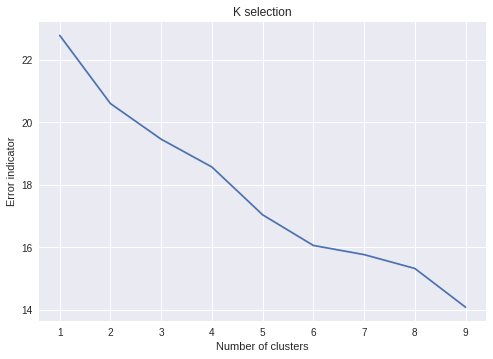

In [46]:
# Finding best k
k_check_df = adam_grouped.drop(['Neighborhood'], axis=1)  

plt.style.use("seaborn")
Ks = 10                            # nr of clusters to check
inertia_arr = np.zeros((Ks-1))     # create an empty array of for (Inertia) error values k-means++

for n in range(1,Ks):
    kmeans_model = KMeans(n_clusters=n, random_state=1, init = 'random', n_init = 30, verbose=0).fit(k_check_df) # 'k-means++'
    inertia_arr[n-1] = kmeans_model.inertia_  # Inertia is a measure of how internally coherent clusters are
 
plt.plot(range(1,Ks), inertia_arr)
plt.xlabel("Number of clusters")
plt.ylabel("Error indicator")
plt.title("K selection")
plt.show()

There is not really a kink that we can help us a lot. Let's check a distribution of 4 clusters

In [87]:
k_check_df = adam_grouped.drop(['Neighborhood'], axis=1)
kclusters = 4
kmeans_model = KMeans(n_clusters=kclusters, random_state=1, init = 'random', n_init = 30, verbose=0).fit(k_check_df)

# check cluster labels distribution
#distr = pd.DataFrame(kmeans_model.labels_)
#distr.value_counts()

(cluster,counts) = np.unique(kmeans_model.labels_, return_counts=True)
for i in range(len(cluster)):
    print('Cluster {} has {} counts' .format(cluster[i], str(counts[i])))

Cluster 0 has 69 counts
Cluster 1 has 12 counts
Cluster 2 has 4 counts
Cluster 3 has 1 counts


Let's create a new dataframe that includes the cluster label as well as the top 10 venues for each neighborhood as well as the safety index

In [48]:
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans_model.labels_)                        # add cluster labels
adam_merged = pd.merge(adam_nb_df,neighborhoods_venues_sorted,how='inner',on='Neighborhood')  # merge with amsterdam neighborhood info

In [49]:
print('Shape of the merged dataframe (rows,columns) : ', adam_merged.shape)
print('Check data types : ', adam_merged.info())
print('Dataframe:')
adam_merged.head()

Shape of the merged dataframe (rows,columns) :  (86, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 85
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Neighborhood            86 non-null     object  
 1   Neighb_ad               86 non-null     object  
 2   Latitude                86 non-null     float64 
 3   Longitude               86 non-null     float64 
 4   Safety_index            86 non-null     float64 
 5   Safety_index_binned     86 non-null     category
 6   Cluster                 86 non-null     int32   
 7   1st Most Common Venue   86 non-null     object  
 8   2nd Most Common Venue   86 non-null     object  
 9   3rd Most Common Venue   86 non-null     object  
 10  4th Most Common Venue   86 non-null     object  
 11  5th Most Common Venue   86 non-null     object  
 12  6th Most Common Venue   86 non-null     object  
 13  7th Most Common Venue   8

,Neighborhood,Neighb_ad,Latitude,Longitude,Safety_index,Safety_index_binned,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Burgwallen-Oude Zijde,burgwallen-oude-zijde,52.372575,4.896949,175.88,unsafe,0,Bakery,Coffee Shop,Bar,Hotel,Liquor Store,Board Shop,Steakhouse,Church,Cocktail Bar,Pub
1,Burgwallen-Nieuwe Zijde,burgwallen-nieuwe-zijde,52.375705,4.895533,190.19,unsafe,0,Coffee Shop,Cheese Shop,Hotel,Bar,Dessert Shop,Cocktail Bar,Fast Food Restaurant,Marijuana Dispensary,Science Museum,Salon / Barbershop
2,Grachtengordel-West,grachtengordel-west,52.373712,4.886839,84.96,safe,0,Hotel,Clothing Store,Deli / Bodega,Furniture / Home Store,Marijuana Dispensary,Sandwich Place,Miscellaneous Shop,Souvenir Shop,Road,Restaurant
3,Grachtengordel-Zuid,grachtengordel-zuid,52.364828,4.893345,153.32,unsafe,0,Movie Theater,Italian Restaurant,Hotel,Chinese Restaurant,Restaurant,Speakeasy,Sushi Restaurant,Tapas Restaurant,Juice Bar,Clothing Store
4,Nieuwmarkt/Lastage,nieuwmarktlastage,52.372429,4.905630,113.79,safe,1,Hotel,Restaurant,Art Gallery,Coffee Shop,Cocktail Bar,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE


Let's visualize the calculated clusters


In [76]:
# create map
map_clusters = folium.Map(location=[latitude_adam, longitude_adam], zoom_start=12, width='100%', height='100%')
map_small = MiniMap(position = 'topleft', center_fixed = (latitude_adam, longitude_adam), zoom_level_fixed = 8)
map_small.add_to(map_clusters)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nbh, cluster in zip(adam_merged['Latitude'], adam_merged['Longitude'], adam_merged['Neighborhood'], adam_merged['Cluster']):
    label = folium.Popup(str(nbh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

print(' Cluster 0: red\n','Cluster 1: purple\n', 'Cluster 2: blue\n', 'Cluster 3: yellow')       
map_clusters

 Cluster 0: red
 Cluster 1: purple
 Cluster 2: blue
 Cluster 3: yellow



## Examine clusters 
Determine the discriminating venue categories that distinguish each cluster

In [51]:
# function to count total number of Foursquare venues per clustered neigborhoods
def venues_count(cluster_df):
  venue_count_df = pd.DataFrame(columns=['Neighborhood', 'Venues count'])
  for nbh in cluster_df['Neighborhood']:
      venue_count = adam_venues.loc[adam_venues['Neighborhood'] == nbh].shape[0]
      venue_count_df = venue_count_df.append({'Neighborhood': nbh, 'Venues count': venue_count}, ignore_index=True)
  return venue_count_df

### Cluster 0 : Bar, food, restaurants


In [115]:
print('Cluster 0 has {} neighborhoods' .format(str(cluster0['Neighborhood'].count())))

Cluster 0 has 69 neighborhoods


Total number of venues per neighborhood from  in Foursquare

In [103]:
cluster0 = adam_merged.loc[adam_merged['Cluster'] == 0, adam_merged.columns[[0] + list(range(7, adam_merged.shape[1]))]]  # create subframe of cluster 0
cluster0_venuescount = venues_count(cluster0)
cluster0_venuescount.sort_values('Venues count', ascending=False).head()

,Neighborhood,Venues count
18,Oude Pijp,43
12,Da Costabuurt,33
13,Kinkerbuurt,30
67,"Bijlmer Centrum (D,F,H)",26
1,Burgwallen-Nieuwe Zijde,25


In [108]:
cluster0.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Burgwallen-Oude Zijde,Bakery,Coffee Shop,Bar,Hotel,Liquor Store,Board Shop,Steakhouse,Church,Cocktail Bar,Pub
1,Burgwallen-Nieuwe Zijde,Coffee Shop,Cheese Shop,Hotel,Bar,Dessert Shop,Cocktail Bar,Fast Food Restaurant,Marijuana Dispensary,Science Museum,Salon / Barbershop
2,Grachtengordel-West,Hotel,Clothing Store,Deli / Bodega,Furniture / Home Store,Marijuana Dispensary,Sandwich Place,Miscellaneous Shop,Souvenir Shop,Road,Restaurant
3,Grachtengordel-Zuid,Movie Theater,Italian Restaurant,Hotel,Chinese Restaurant,Restaurant,Speakeasy,Sushi Restaurant,Tapas Restaurant,Juice Bar,Clothing Store
6,Jordaan,Bar,Café,Sandwich Place,Afghan Restaurant,Indonesian Restaurant,Marijuana Dispensary,Food & Drink Shop,Latin American Restaurant,Juice Bar,French Restaurant


Count of most frequent venue categories

In [104]:
cluster0_top5venues = pd.DataFrame(pd.DataFrame(list(adam_merged[adam_merged['Cluster'] == 0].iloc[:,7:16].values.flatten()), columns = ['Venues count'])['Venues count'].value_counts()[1:6])
cluster0_top5venues

,Venues count
Bar,19
Café,17
Supermarket,16
Bakery,13
Restaurant,12


As we saw earlier, restaurants can have several categories.<br>
I will split up the neighborhoods with enough restaurants (Cluster 4)


### Cluster 1 

The number of venues per neighborhood in this cluster is too small to rank them according to 'most common'. E.g. neighborhood 'Vondelbuurt' has 7 venues but each of a different category, so the sorting on 'Most common' is arbitrary.

In [116]:
print('Cluster 1 has {} neighborhoods' .format(str(cluster1['Neighborhood'].count())))

Cluster 1 has 12 neighborhoods


Total number of venues per neighborhood from  in Foursquare

In [100]:
cluster1 = adam_merged.loc[adam_merged['Cluster'] == 1, adam_merged.columns[[0] + list(range(7, adam_merged.shape[1]))]]  # create subframe of cluster 1
cluster1_venuescount = venues_count(cluster1)
cluster1_venuescount.sort_values('Neighborhood', ascending=False).iloc[:]

,Neighborhood,Venues count
4,Zeeburgereiland/Nieuwe Diep,5
3,Vondelbuurt,7
5,Sloterdijk,2
7,Rijnbuurt,4
8,Omval/Overamstel,6
0,Nieuwmarkt/Lastage,9
6,Hoofddorppleinbuurt,6
1,Haarlemmerbuurt,2
10,Chassébuurt,3
2,Centrale Markt,2


In [98]:
cluster1.iloc[:].sort_values(by=['Neighborhood'] )

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
65,Banne Buiksloot,Turkish Restaurant,Park,Restaurant,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
81,Buitenveldert-West,Restaurant,Gastropub,Track,Café,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
13,Centrale Markt,Restaurant,Seafood Restaurant,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
68,Chassébuurt,Food & Drink Shop,Restaurant,Electronics Store,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
5,Haarlemmerbuurt,Restaurant,Bar,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
42,Hoofddorppleinbuurt,Fast Food Restaurant,Diner,Restaurant,Supermarket,Bar,Café,NO VENUE,NO VENUE,NO VENUE,NO VENUE
4,Nieuwmarkt/Lastage,Hotel,Restaurant,Art Gallery,Coffee Shop,Cocktail Bar,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
54,Omval/Overamstel,Restaurant,Garden,Hotel,Men's Store,Sandwich Place,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
51,Rijnbuurt,Restaurant,Park,Café,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE
34,Sloterdijk,Nightclub,Café,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE,NO VENUE


### Cluster 2

Outside area, hardly any venues available

In [117]:
print('Cluster 2 has {} neighborhoods' .format(str(cluster2['Neighborhood'].count())))

Cluster 2 has 4 neighborhoods


Total number of venues per neighborhood from  in Foursquare

In [57]:
cluster2 = adam_merged.loc[adam_merged['Cluster'] == 2, adam_merged.columns[[0] + list(range(7, adam_merged.shape[1]))]]  # create subframe of cluster 2
cluster2_venuescount = venues_count(cluster2)
cluster2_venuescount.sort_values('Venues count', ascending=False).head()

,Neighborhood,Venues count
0,Tuindorp Buiksloot,3
1,Tuindorp Oostzaan,3
3,Overtoomse Veld,3
2,Elzenhagen,1


### Cluster 3
Residential area


Total number of venues per neighborhood from  in Foursquare

In [58]:
cluster3 = adam_merged.loc[adam_merged['Cluster'] == 3, adam_merged.columns[[0] + list(range(7, adam_merged.shape[1]))]]  # create subframe cluster 3
cluster3_venuescount = venues_count(cluster3)
cluster3_venuescount.sort_values('Venues count', ascending=False).head()

,Neighborhood,Venues count
0,Gein,1


### Cluster 4 : Multiple restaurants

Let's further specify cluster 0.<br>
For our target audience we have to focus on the restaurants.<br>
As we saw earlier, restaurants can have several categories<br> 
Let's filter out the neighborhoods of this cluster with more then 5 restaurants

In [110]:
rest_df = pd.DataFrame(columns=['Neighborhood', 'Venue Category'])
rest_cnt = pd.DataFrame()

# make df with venues for all Neighborhood with > 5 venues 
for nbh in cluster0['Neighborhood']:
  tmp_df = adam_venues[adam_venues['Neighborhood'] == nbh]   
  if tmp_df.shape[0] > 5:
    for i in range(tmp_df.shape[0]):
      if "Restaurant" in str(tmp_df['Venue Category'].iloc[i]):
        rest_df = rest_df.append({'Neighborhood': nbh, 'Venue Category': tmp_df.iloc[i,6]},ignore_index=True)

# filter for > 5 restaurants 
tmp_df = rest_df.groupby(['Neighborhood']).count().reset_index()
for i in range(tmp_df.shape[0]):
  if tmp_df.iloc[i,1] > 5:
    rest_cnt = rest_cnt.append(tmp_df.iloc[i])
rest_cnt.rename(columns={'Venue Category': 'Venue Count'}, inplace=True)

print('Amsterdam neighborhoods with more then 5 restaurants in this cluster:\n')
list(rest_cnt['Neighborhood'])

Amsterdam neighborhoods with more then 5 restaurants in this cluster:



['Bijlmer Centrum (D,F,H)',
 'Da Costabuurt',
 'Grachtengordel-Zuid',
 'Indische Buurt West',
 'Kinkerbuurt',
 'Landlust',
 'Nieuwe Pijp',
 'Oude Pijp',
 'Overtoomse Sluis',
 'Stadionbuurt',
 'Van Lennepbuurt',
 'Weesperbuurt/Plantage',
 'Zuid Pijp']

Let's change the cluster number of these neigborhoods in cluster 4

In [ ]:
adam_merged4 = adam_merged.copy()
for i in range(adam_merged4.shape[0]):
  if adam_merged4['Neighborhood'][i] in list(rest_cnt['Neighborhood']):
     adam_merged4['Cluster'][i] = 4

In [114]:
print('Cluster 4 has {} neighborhoods' .format(str(cluster4['Neighborhood'].count())))

Cluster 4 has 13 neighborhoods


Total number of venues per neighborhood from  in Foursquare

In [123]:
cluster4 = adam_merged.loc[adam_merged4['Cluster'] == 4, adam_merged4.columns[[0] + list(range(7, adam_merged4.shape[1]))]]  # create subframe cluster 4
cluster4_venuescount = venues_count(cluster4)
cluster4_venuescount.sort_values('Neighborhood', ascending=False).iloc[:]

,Neighborhood,Venues count
8,Zuid Pijp,12
1,Weesperbuurt/Plantage,20
4,Van Lennepbuurt,21
11,Stadionbuurt,23
5,Overtoomse Sluis,19
6,Oude Pijp,43
7,Nieuwe Pijp,16
10,Landlust,16
3,Kinkerbuurt,30
9,Indische Buurt West,16


In [152]:
cluster4.iloc[:]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Grachtengordel-Zuid,Movie Theater,Italian Restaurant,Hotel,Chinese Restaurant,Restaurant,Speakeasy,Sushi Restaurant,Tapas Restaurant,Juice Bar,Clothing Store
8,Weesperbuurt/Plantage,Pizza Place,Café,Italian Restaurant,Coffee Shop,Theater,Smoke Shop,Sandwich Place,Russian Restaurant,Japanese Restaurant,Restaurant
15,Da Costabuurt,Coffee Shop,Grocery Store,Indonesian Restaurant,Café,Pizza Place,Mexican Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Ice Cream Shop,Italian Restaurant
16,Kinkerbuurt,Modern European Restaurant,Vegetarian / Vegan Restaurant,Bar,Yoga Studio,Beer Bar,Seafood Restaurant,Sandwich Place,Burger Joint,Dance Studio,Movie Theater
17,Van Lennepbuurt,Café,Restaurant,Arts & Crafts Store,Tapas Restaurant,Movie Theater,Market,Seafood Restaurant,Bookstore,Sandwich Place,Food & Drink Shop
19,Overtoomse Sluis,Italian Restaurant,Bar,Sushi Restaurant,Thai Restaurant,Breakfast Spot,Restaurant,Bistro,Beer Bar,Pub,French Restaurant
22,Oude Pijp,Deli / Bodega,South American Restaurant,Dessert Shop,Food Truck,Fish Market,Café,Salad Place,Falafel Restaurant,Italian Restaurant,Japanese Restaurant
23,Nieuwe Pijp,Restaurant,Pizza Place,Yoga Studio,Ice Cream Shop,Middle Eastern Restaurant,Café,Moroccan Restaurant,French Restaurant,Tapas Restaurant,Indie Movie Theater
24,Zuid Pijp,Indian Restaurant,Yoga Studio,Toy / Game Store,Grocery Store,Italian Restaurant,Coffee Shop,Chinese Restaurant,Steakhouse,Thai Restaurant,Gym
29,Indische Buurt West,Italian Restaurant,Pet Store,Cocktail Bar,Fish Market,Café,Middle Eastern Restaurant,Bar,Bakery,Burger Joint,Drugstore


# Results
Ultimately, the analysis resulted in 4 clusters of neighborhoods, in which cluster 4 contains the neighborhoods with which we can answer the question of our client.

In [128]:
#print('Neighborhood distribution across the clusters :')
#adam_merged4['Cluster'].value_counts()

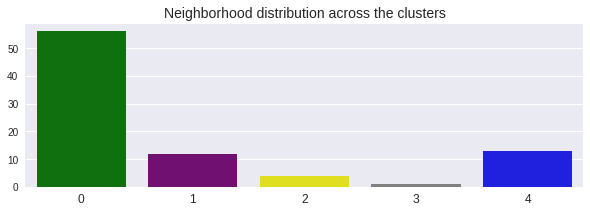

In [148]:
colors = ["green", "purple", "yellow", "gray", "blue"]
fig, ax = plt.subplots(figsize=(10, 3))
ax = sns.barplot(x = adam_merged4['Cluster'].value_counts().index, y = adam_merged4['Cluster'].value_counts().values, palette=(colors))
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12)
ax.yaxis.label.set_size(12)
plt.title('Neighborhood distribution across the clusters', fontsize = 14)
plt.savefig('Neighborhood_distribution_across_the_clusters.jpg')
plt.show()

In [141]:
#print('Neighborhoods in cluster 4: ')
#print(cluster4['Neighborhood'].values)

Cluster 4 contains safe neighborhoods with at least 5 restaurants according to Foursquare:

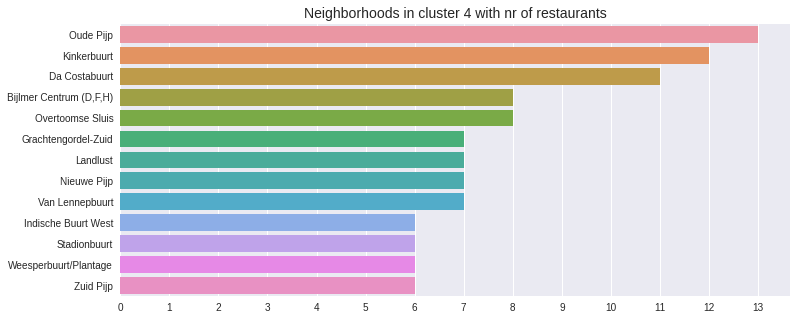

In [150]:
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(x = rest_cnt.sort_values(by= 'Venue Count', ascending=False)['Venue Count'].values,
                 y = rest_cnt.sort_values(by= 'Venue Count', ascending=False)['Neighborhood'].values)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
plt.xticks(np.arange(0, max(rest_cnt.sort_values(by= 'Venue Count', ascending=False)['Venue Count'].values)+1, 1.0))
plt.title('Neighborhoods in cluster 4 with nr of restaurants', fontsize = 14)
plt.savefig('Neighborhoods_in_cluster_4_with_nr_of_restaurants.jpg')
plt.show()

Visualisation

In [151]:
map_final = folium.Map(location=[latitude_adam, longitude_adam], zoom_start=12, width='100%', height='100%')
map_small = MiniMap(position = 'topleft', center_fixed = (latitude_adam, longitude_adam), zoom_level_fixed = 8)
map_small.add_to(map_final)

# create feature groups in order to be able to put cluster4 vs rest on and off seperately 
fg_pref = folium.FeatureGroup(name= 'Preferred Neighborhoods')
fg_non_pref = folium.FeatureGroup(name= 'Other Neighborhoods')

for lat, lon, nbh, saf, clus in zip(adam_merged4['Latitude'], adam_merged4['Longitude'], adam_merged4['Neighborhood'], adam_merged4['Safety_index_binned'],adam_merged4['Cluster']):
    if (clus==4) and saf == 'safe':
       label = folium.Popup(str(nbh) + ', '+ 'Cluster '+ str(clus) + ', '+ str(saf), parse_html=True)
       fg_pref.add_child(folium.CircleMarker([lat, lon], radius=6, popup=label, color='green',fill=True,fill_color='green',fill_opacity=0.7,parse_html=False))

    elif (clus==0) and saf == 'safe':
        label = folium.Popup(str(nbh) + ', '+ 'Cluster '+ str(clus) + ', '+ str(saf), parse_html=True)
        fg_non_pref.add_child(folium.CircleMarker([lat, lon], radius=6, popup=label, color='yellow',fill=True,fill_color='yellow',fill_opacity=0.7,parse_html=False))
   
    elif (clus==1 or clus==2 or clus==3) and saf == 'safe':
        label = folium.Popup(str(nbh) + ', '+ 'Cluster '+ str(clus) + ', '+ str(saf), parse_html=True)
        fg_non_pref.add_child(folium.CircleMarker([lat, lon], radius=6, popup=label, color='blue',fill=True,fill_color='blue',fill_opacity=0.7,parse_html=False))
    
    else:
        label = folium.Popup(str(nbh) + ', '+ 'Cluster '+ str(clus) + ', ' + str(saf), parse_html=True)
        fg_non_pref.add_child(folium.CircleMarker([lat, lon], radius=5, popup=label, color='red',fill=True,fill_color='red',fill_opacity=0.7,parse_html=False))

map_final.add_child(fg_pref)
map_final.add_child(fg_non_pref)
map_final.add_child(folium.LayerControl())

map_final.save("map_final.html")
print(' Cluster 0: yellow\n','Cluster 1,2,3: blue\n', 'Cluster 4: green\n', 'Out of scope due to safety: red\n', 'Topright menu')       
map_final

 Cluster 0: yellow
 Cluster 1,2,3: blue
 Cluster 4: green
 Out of scope due to safety: red
 Topright menu


# Discussion

Although Foursquare database certainly contains venue information about Amsterdam, it is actually not enough to draw meaningful conclusions. Maybe it would have helped to include Yelp or Google as location data providers.<br> 
In retrospect, you could conclude that the use of a clustering technique does not add value in this case, but it was worth the learning experience.

<br><br>
Furthermore the use of a table with 1st Most Common Venue, 2nd Most Common Venue etc can be misleading. It suggests that 1st common venue happen more often than the 2nd etc. But sometimes the venues in a neighborhood are equally divided over venue categories (like in this casus). The fewer the number of venues in a neighborhood, the greater the chance.


# Conclusion

Most important part of my assignment was to provide my client safe neighborhoods where they are within walking distance of nice restaurants.<br>

That was successful, the results section contains a picture of neighborhoods that meet the requirements of the client.<br> 
I have not further analyzed over-represented restaurant types per neighborhood, ratings etc. because no conclusions can be drawn from this because of the limited number of Amsterdam restaurant venues in Foursquare.